In [1]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
from __future__ import print_function
import matplotlib.pyplot as plt
import numpy as np
import os
import sys
import tarfile
from IPython.display import display, Image
from scipy import ndimage
from sklearn.linear_model import LogisticRegression
from six.moves.urllib.request import urlretrieve
from six.moves import cPickle as pickle

# Config the matlotlib backend as plotting inline in IPython
%matplotlib inline

In [2]:
url = 'http://commondatastorage.googleapis.com/books1000/'
last_percent_reported = None

def download_progress_hook(count, blockSize, totalSize):
  """A hook to report the progress of a download. This is mostly intended for users with
  slow internet connections. Reports every 1% change in download progress.
  """
  global last_percent_reported
  percent = int(count * blockSize * 100 / totalSize)

  if last_percent_reported != percent:
    if percent % 5 == 0:
      sys.stdout.write("%s%%" % percent)
      sys.stdout.flush()
    else:
      sys.stdout.write(".")
      sys.stdout.flush()
      
    last_percent_reported = percent
        
def maybe_download(filename, expected_bytes, force=False):
  """Download a file if not present, and make sure it's the right size."""
  if force or not os.path.exists(filename):
    print('Attempting to download:', filename) 
    filename, _ = urlretrieve(url + filename, filename, reporthook=download_progress_hook)
    print('\nDownload Complete!')
  statinfo = os.stat(filename)
  if statinfo.st_size == expected_bytes:
    print('Found and verified', filename)
  else:
    raise Exception(
      'Failed to verify ' + filename + '. Can you get to it with a browser?')
  return filename

train_filename = maybe_download('notMNIST_large.tar.gz', 247336696)
test_filename = maybe_download('notMNIST_small.tar.gz', 8458043)

Found and verified notMNIST_large.tar.gz
Found and verified notMNIST_small.tar.gz


In [3]:
num_classes = 10
np.random.seed(133)

def maybe_extract(filename, force=False):
  root = os.path.splitext(os.path.splitext(filename)[0])[0]  # remove .tar.gz
  if os.path.isdir(root) and not force:
    # You may override by setting force=True.
    print('%s already present - Skipping extraction of %s.' % (root, filename))
  else:
    print('Extracting data for %s. This may take a while. Please wait.' % root)
    tar = tarfile.open(filename)
    sys.stdout.flush()
    tar.extractall()
    tar.close()
  data_folders = [
    os.path.join(root, d) for d in sorted(os.listdir(root))
    if os.path.isdir(os.path.join(root, d))]
  if len(data_folders) != num_classes:
    raise Exception(
      'Expected %d folders, one per class. Found %d instead.' % (
        num_classes, len(data_folders)))
  print(data_folders)
  return data_folders
  
train_folders = maybe_extract(train_filename)
test_folders = maybe_extract(test_filename)

notMNIST_large already present - Skipping extraction of notMNIST_large.tar.gz.
['notMNIST_large\\A', 'notMNIST_large\\B', 'notMNIST_large\\C', 'notMNIST_large\\D', 'notMNIST_large\\E', 'notMNIST_large\\F', 'notMNIST_large\\G', 'notMNIST_large\\H', 'notMNIST_large\\I', 'notMNIST_large\\J']
notMNIST_small already present - Skipping extraction of notMNIST_small.tar.gz.
['notMNIST_small\\A', 'notMNIST_small\\B', 'notMNIST_small\\C', 'notMNIST_small\\D', 'notMNIST_small\\E', 'notMNIST_small\\F', 'notMNIST_small\\G', 'notMNIST_small\\H', 'notMNIST_small\\I', 'notMNIST_small\\J']


In [4]:
import random

all_training  = []
all_test      = []

for train_dir in train_folders:
    for train_file in os.listdir(train_dir):
        all_training.append(os.path.join(train_dir, train_file))
        
for test_dir in test_folders:
    for test_file in os.listdir(test_dir):
        all_test.append(os.path.join(test_dir, test_file))

five_training = random.sample(all_training, 5)
five_test     = random.sample(all_test, 5)
    
for img in five_training+five_test:
    display(Image(img))


In [5]:
image_size = 28  # Pixel width and height.
pixel_depth = 255.0  # Number of levels per pixel.

def load_letter(folder, min_num_images):
  """Load the data for a single letter label."""
  image_files = os.listdir(folder)
  dataset = np.ndarray(shape=(len(image_files), image_size, image_size),
                         dtype=np.float32)
  print(folder)
  num_images = 0
  for image in image_files:
    image_file = os.path.join(folder, image)
    try:
      image_data = (ndimage.imread(image_file).astype(float) - 
                    pixel_depth / 2) / pixel_depth
      if image_data.shape != (image_size, image_size):
        raise Exception('Unexpected image shape: %s' % str(image_data.shape))
      dataset[num_images, :, :] = image_data
      num_images = num_images + 1
    except IOError as e:
      print('Could not read:', image_file, ':', e, '- it\'s ok, skipping.')
    
  dataset = dataset[0:num_images, :, :]
  if num_images < min_num_images:
    raise Exception('Many fewer images than expected: %d < %d' %
                    (num_images, min_num_images))
    
  print('Full dataset tensor:', dataset.shape)
  print('Mean:', np.mean(dataset))
  print('Standard deviation:', np.std(dataset))
  return dataset
        
def maybe_pickle(data_folders, min_num_images_per_class, force=False):
  dataset_names = []
  for folder in data_folders:
    set_filename = folder + '.pickle'
    dataset_names.append(set_filename)
    if os.path.exists(set_filename) and not force:
      # You may override by setting force=True.
      print('%s already present - Skipping pickling.' % set_filename)
    else:
      print('Pickling %s.' % set_filename)
      dataset = load_letter(folder, min_num_images_per_class)
      try:
        with open(set_filename, 'wb') as f:
          pickle.dump(dataset, f, pickle.HIGHEST_PROTOCOL)
      except Exception as e:
        print('Unable to save data to', set_filename, ':', e)
  
  return dataset_names

train_datasets = maybe_pickle(train_folders, 45000)
test_datasets = maybe_pickle(test_folders, 1800)


notMNIST_large\A.pickle already present - Skipping pickling.
notMNIST_large\B.pickle already present - Skipping pickling.
notMNIST_large\C.pickle already present - Skipping pickling.
notMNIST_large\D.pickle already present - Skipping pickling.
notMNIST_large\E.pickle already present - Skipping pickling.
notMNIST_large\F.pickle already present - Skipping pickling.
notMNIST_large\G.pickle already present - Skipping pickling.
notMNIST_large\H.pickle already present - Skipping pickling.
notMNIST_large\I.pickle already present - Skipping pickling.
notMNIST_large\J.pickle already present - Skipping pickling.
notMNIST_small\A.pickle already present - Skipping pickling.
notMNIST_small\B.pickle already present - Skipping pickling.
notMNIST_small\C.pickle already present - Skipping pickling.
notMNIST_small\D.pickle already present - Skipping pickling.
notMNIST_small\E.pickle already present - Skipping pickling.
notMNIST_small\F.pickle already present - Skipping pickling.
notMNIST_small\G.pickle 

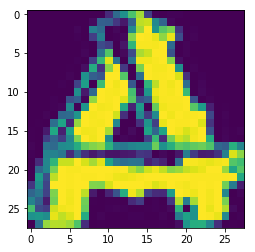

In [6]:
# index 0 should be all As, 1 = all Bs, etc.
pickle_file = train_datasets[0]  

# With would automatically close the file after the nested block of code
with open(pickle_file, 'rb') as f:
    
    # unpickle
    letter_set = pickle.load(f)  
    
    # pick a random image index
    sample_idx = np.random.randint(len(letter_set))
    
    # extract a 2D slice
    sample_image = letter_set[sample_idx, :, :]  
    plt.figure()
    
    # display it
    plt.imshow(sample_image)  


In [7]:
def make_arrays(nb_rows, img_size):
  if nb_rows:
    dataset = np.ndarray((nb_rows, img_size, img_size), dtype=np.float32)
    labels = np.ndarray(nb_rows, dtype=np.int32)
  else:
    dataset, labels = None, None
  return dataset, labels

def merge_datasets(pickle_files, train_size, valid_size=0):
  num_classes = len(pickle_files)
  valid_dataset, valid_labels = make_arrays(valid_size, image_size)
  train_dataset, train_labels = make_arrays(train_size, image_size)
  vsize_per_class = valid_size // num_classes
  tsize_per_class = train_size // num_classes
    
  start_v, start_t = 0, 0
  end_v, end_t = vsize_per_class, tsize_per_class
  end_l = vsize_per_class+tsize_per_class
  for label, pickle_file in enumerate(pickle_files):       
    try:
      with open(pickle_file, 'rb') as f:
        letter_set = pickle.load(f)
        # let's shuffle the letters to have random validation and training set
        np.random.shuffle(letter_set)
        if valid_dataset is not None:
          valid_letter = letter_set[:vsize_per_class, :, :]
          valid_dataset[start_v:end_v, :, :] = valid_letter
          valid_labels[start_v:end_v] = label
          start_v += vsize_per_class
          end_v += vsize_per_class
                    
        train_letter = letter_set[vsize_per_class:end_l, :, :]
        train_dataset[start_t:end_t, :, :] = train_letter
        train_labels[start_t:end_t] = label
        start_t += tsize_per_class
        end_t += tsize_per_class
    except Exception as e:
      print('Unable to process data from', pickle_file, ':', e)
      raise
    
  return valid_dataset, valid_labels, train_dataset, train_labels
            
            
train_size = 504090
valid_size =  25000
test_size  =  18720

valid_dataset, valid_labels, train_dataset, train_labels = merge_datasets(
  train_datasets, train_size, valid_size)
_, _, test_dataset, test_labels = merge_datasets(test_datasets, test_size)

print('Training:', train_dataset.shape, train_labels.shape)
print('Validation:', valid_dataset.shape, valid_labels.shape)
print('Testing:', test_dataset.shape, test_labels.shape)


Training: (504090, 28, 28) (504090,)
Validation: (25000, 28, 28) (25000,)
Testing: (18720, 28, 28) (18720,)


In [8]:
def randomize(dataset, labels):
  permutation = np.random.permutation(labels.shape[0])
  shuffled_dataset = dataset[permutation,:,:]
  shuffled_labels = labels[permutation]
  return shuffled_dataset, shuffled_labels
train_dataset, train_labels = randomize(train_dataset, train_labels)
test_dataset, test_labels = randomize(test_dataset, test_labels)
valid_dataset, valid_labels = randomize(valid_dataset, valid_labels)


E

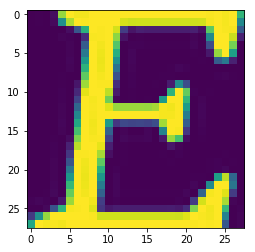

G

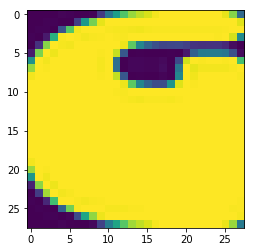

C

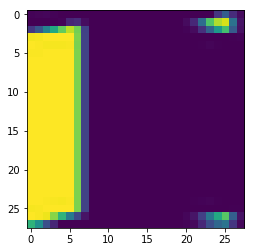

H

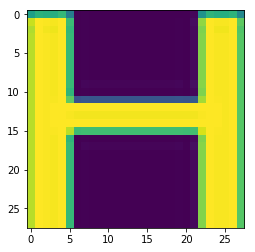

B

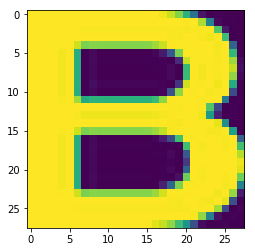

J

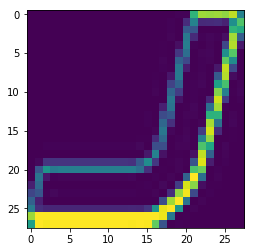

J

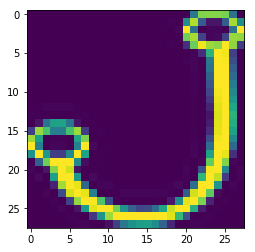

I

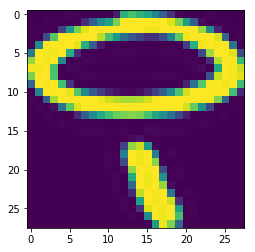

C

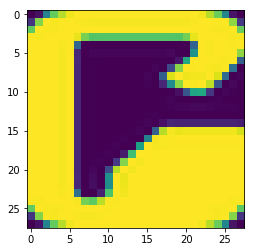

C

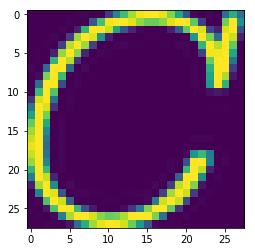

E

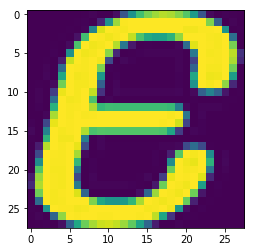

F

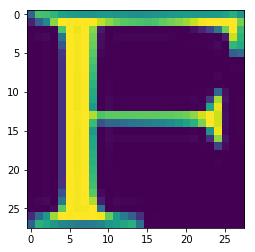

I

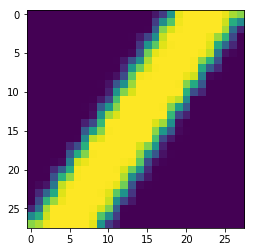

H

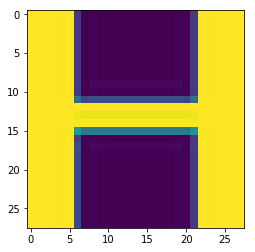

A

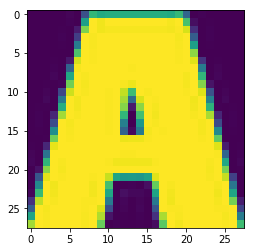

In [9]:
for i in range(5):
    
    letters = ["A", "B", "C", "D", "E", "F", "G", "H", "I", "J"]
    
    print(letters[train_labels[i]], end="")
    plt.imshow(train_dataset[i])
    plt.show()
    
    print(letters[test_labels[i]], end="")
    plt.imshow(test_dataset[i])
    plt.show()
    
    print(letters[valid_labels[i]], end="")
    plt.imshow(valid_dataset[i])
    plt.show()


In [10]:
pickle_file = 'notMNIST.pickle'

try:
  f = open(pickle_file, 'wb')
  save = {
    'train_dataset': train_dataset,
    'train_labels': train_labels,
    'valid_dataset': valid_dataset,
    'valid_labels': valid_labels,
    'test_dataset': test_dataset,
    'test_labels': test_labels,
    }
  pickle.dump(save, f, pickle.HIGHEST_PROTOCOL)
  f.close()
except Exception as e:
  print('Unable to save data to', pickle_file, ':', e)
  raise


In [11]:
statinfo = os.stat(pickle_file)
print('Compressed pickle size:', statinfo.st_size)


Compressed pickle size: 1720123924


In [15]:
train_set = set()
sanitized_train_mask = np.ones(len(train_dataset), dtype=bool)

for i in range(len(train_dataset)):
  hashable_letter = train_dataset[i,:,:].tostring()
  if hashable_letter not in train_set:
    train_set.add(hashable_letter)
  else:
     sanitized_train_mask[i] = False

sanitized_train_dataset = train_dataset[sanitized_train_mask]


validation_set = set()
sanitized_valid_mask = np.ones(len(valid_dataset), dtype=bool)

for i in range(len(valid_dataset)):
  hashable_letter = valid_dataset[i,:,:].tostring()
  if hashable_letter not in validation_set:
    validation_set.add(hashable_letter)
  else:
     sanitized_valid_mask[i] = False

sanitized_valid_dataset = valid_dataset[sanitized_valid_mask]


test_set = set()
sanitized_test_mask = np.ones(len(test_dataset), dtype=bool)

for i in range(len(test_dataset)):
  hashable_letter = test_dataset[i,:,:].tostring()
  if hashable_letter not in test_set:
    test_set.add(hashable_letter)
  else:
     sanitized_test_mask[i] = False

sanitized_test_dataset = test_dataset[sanitized_test_mask]


print( "Unique elements in training set: {:,d}/{:,d}".format( len(train_set), len(train_dataset) ) )
print( "Unique elements in validation set: {:,d}/{:,d}".format( len(validation_set), len(valid_dataset) ) )
print( "Unique elements in test set: {:,d}/{:,d}".format( len(test_set), len(test_dataset) ) )


print()
print( "Overlap elements between train and test set: {:,d}".format( len(train_set.intersection(test_set)) ) )
print( "Overlap elements between train and validation set: {:,d}".format( len(train_set.intersection(validation_set)) ) )
print( "Overlap elements between test and validation set: {:,d}".format( len(test_set.intersection(validation_set)) ) )


Unique elements in training set: 442,222/504,090
Unique elements in validation set: 24,533/25,000
Unique elements in test set: 18,228/18,720

Overlap elements between train and test set: 4,403
Overlap elements between train and validation set: 4,829
Overlap elements between test and validation set: 303


D:\Programs\Anaconda\lib\site-packages\ipykernel_launcher.py:9: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  if __name__ == '__main__':
D:\Programs\Anaconda\lib\site-packages\ipykernel_launcher.py:10: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.3.0.
Use Pillow instead: ``numpy.array(Image.fromarray(arr).resize())``.
  # Remove the CWD from sys.path while we load stuff.



Nonsimilar elements in training set: 291,179/442,222
Nonsimilar elements in validation set: 20,543/24,533
Nonsimilar elements in test set: 14,660/18,228

Overlap elements between nonsimilar train and test sets: 7,497
Overlap elements between nonsimilar train and validation sets: 8,902
Overlap elements between nonsimilar test and validation sets: 1,938

Sample of similar pairs in test set
New letter
  letter 1


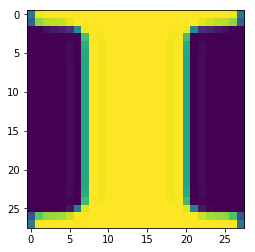

  letter 2


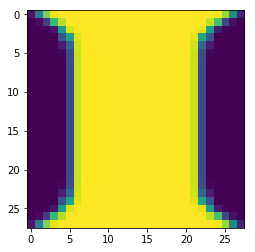

New letter
  letter 1


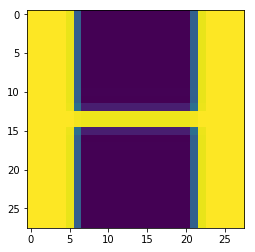

  letter 2


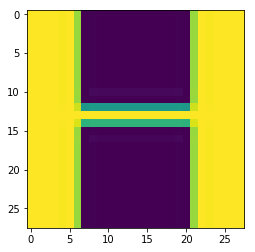

New letter
  letter 1


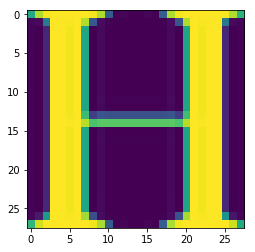

  letter 2


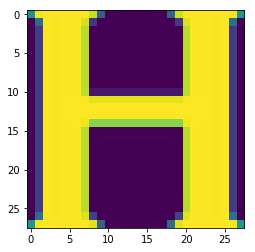

New letter
  letter 1


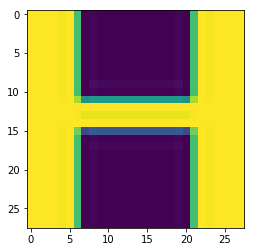

  letter 2


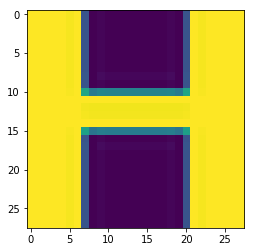

New letter
  letter 1


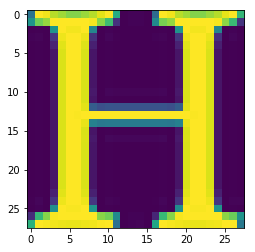

  letter 2


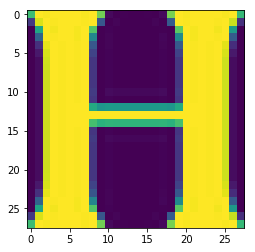

In [17]:
### optional: What about near duplicates between datasets? (images that are almost identical)

# adapted from: http://blog.iconfinder.com/detecting-duplicate-images-using-python/

import scipy

def dhash(image, hash_size = 8):
  # # Grayscale and shrink the image in one step.
  image = np.fromstring(image, dtype='float32').reshape((28,28))
  image = scipy.misc.imresize(image, (hash_size + 1, hash_size), interp="bilinear", mode="L")

  # Compare adjacent pixels.
  difference = []
  for row in range(hash_size):
      for col in range(hash_size):
          pixel_left = image[col, row]
          pixel_right = image[col + 1, row]
          difference.append(pixel_left > pixel_right)

  # Convert the binary array to a hexadecimal string.
  decimal_value = 0
  hex_string = []
  for index, value in enumerate(difference):
      if value:
          decimal_value += 2**(index % 8)
      if (index % 8) == 7:
          hex_string.append(hex(decimal_value)[2:].rjust(2, '0'))
          decimal_value = 0

  return ''.join(hex_string)


train_nonsimilar_set = set()
nonsimilar_train_mask = np.ones(len(sanitized_train_dataset), dtype=bool)
for i in range(len(sanitized_train_dataset)):
  similar_letter_hash = dhash(sanitized_train_dataset[i,:,:])
  if similar_letter_hash not in train_nonsimilar_set:
    train_nonsimilar_set.add(similar_letter_hash)
  else:
     nonsimilar_train_mask[i] = False

nonsimilar_train_dataset = sanitized_train_dataset[nonsimilar_train_mask]


validation_nonsimilar_set = set()
nonsimilar_valid_mask = np.ones(len(sanitized_valid_dataset), dtype=bool)
for i in range(len(sanitized_valid_dataset)):
  similar_letter_hash = dhash(sanitized_valid_dataset[i,:,:])
  if similar_letter_hash not in validation_nonsimilar_set:
    validation_nonsimilar_set.add(similar_letter_hash)
  else:
     nonsimilar_valid_mask[i] = False

nonsimilar_valid_dataset = sanitized_valid_dataset[nonsimilar_valid_mask]


seen_hashes = {}
identical_hashes = []
test_nonsimilar_set = set()
nonsimilar_test_mask = np.ones(len(sanitized_test_dataset), dtype=bool)
for i in range(len(sanitized_test_dataset)):
  similar_letter_hash = dhash(sanitized_test_dataset[i,:,:])
  seen_hashes.setdefault(similar_letter_hash, []).append(i)
  if similar_letter_hash not in test_nonsimilar_set:
    test_nonsimilar_set.add(similar_letter_hash)
  else:
     nonsimilar_test_mask[i] = False
     identical_hashes.append(similar_letter_hash)

nonsimilar_test_dataset = sanitized_test_dataset[nonsimilar_test_mask]

print()
print( "Nonsimilar elements in training set: {:,d}/{:,d}".format( len(train_nonsimilar_set), len(sanitized_train_dataset) ) )
print( "Nonsimilar elements in validation set: {:,d}/{:,d}".format( len(validation_nonsimilar_set), len(sanitized_valid_dataset) ) )
print( "Nonsimilar elements in test set: {:,d}/{:,d}".format( len(test_nonsimilar_set), len(sanitized_test_dataset) ) )


print()
print( "Overlap elements between nonsimilar train and test sets: {:,d}".format( len(train_nonsimilar_set.intersection(test_nonsimilar_set)) ) )
print( "Overlap elements between nonsimilar train and validation sets: {:,d}".format( len(train_nonsimilar_set.intersection(validation_nonsimilar_set)) ) )
print( "Overlap elements between nonsimilar test and validation sets: {:,d}".format( len(test_nonsimilar_set.intersection(validation_nonsimilar_set)) ) )

print()
print("Sample of similar pairs in test set")
for ih in identical_hashes[:5]:

  image1, image2 = random.sample(seen_hashes[ih] , 2)

  print("New letter")

  print("  letter 1")
  plt.imshow(sanitized_test_dataset[image1,:,:])
  plt.show()

  print("  letter 2")
  plt.imshow(sanitized_test_dataset[image2,:,:])
  plt.show()


In [18]:
# First Approach. the faster one.
# Here you have 200000 samples
# 28 x 28 features
# We have to reshape them because scikit-learn expects (n_samples, n_features)
train_dataset.shape


(504090, 28, 28)

In [19]:
test_dataset.shape

(18720, 28, 28)

In [20]:
# Prepare training data
samples, width, height = train_dataset.shape
X_train = np.reshape(train_dataset,(samples,width*height))
y_train = train_labels

# Prepare testing data
samples, width, height = test_dataset.shape
X_test = np.reshape(test_dataset,(samples,width*height))
y_test = test_labels


In [21]:
# Import
from sklearn.linear_model import LogisticRegression

# Instantiate
lg = LogisticRegression(multi_class='multinomial', solver='lbfgs', random_state=42, verbose=1, max_iter=1000, n_jobs=-1)

# Fit
lg.fit(X_train, y_train)

# Predict
y_pred = lg.predict(X_test)

# Score
from sklearn import metrics
metrics.accuracy_score(y_test, y_pred)


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed: 31.7min finished


0.9003739316239316